In [16]:
import numpy as np
from model import Model
from optimizer import Optimizer
from ukf import UKF
import tensorflow as tf
from utils import gather_data, split_data, unzip, login
import matplotlib.pyplot as plt
from tda import calc_covars
from wt_ukf import WeightUKF



In [9]:
x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')

x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')

x_val = np.load('x_val.npy')
y_val = np.load('y_val.npy')

In [10]:
print(x_test.shape)
print(y_test.shape)
print('printed shapes')

file1 = 'C:\\Users\\chinm\\PycharmProjects\\StockTracking\\open_model'
# del file2, file3, file4
# file2 = 'C:\\Users\\chinm\\PycharmProjects\\StockTracking\\high_model'
# file3 = 'C:\\Users\\chinm\\PycharmProjects\\StockTracking\\low_model'
# file4 = 'C:\\Users\\chinm\\PycharmProjects\\StockTracking\\close_model'

model1 = Model(filepath=file1)
# del model2, model3, model4
# model2 = Model(filepath=file2)
# model3 = Model(filepath=file3)
# model4 = Model(filepath=file4)

(376, 4, 4)
(376, 4)
printed shapes


In [19]:
print(x_test[0:10, 0, :].T)
print()
print(np.mean(x_test[0:10, 0, :], axis=0))
print()
print(np.cov(x_test[0:10, 0, :].T))

[[41.60255 43.80625 43.97    44.5625  46.295   46.2475  46.6375  46.935
  47.3725  47.2525 ]
 [43.80625 43.97    44.5625  46.295   46.2475  46.6375  46.935   47.3725
  47.2525  46.695  ]
 [43.97    44.5625  46.295   46.2475  46.6375  46.935   47.3725  47.2525
  46.695   46.5175 ]
 [44.5625  46.295   46.2475  46.6375  46.935   47.3725  47.2525  46.695
  46.5175  47.     ]]

[45.46813  45.977375 46.2485   46.5515  ]

[[3.59888665 2.35262587 1.83499915 1.24613235]
 [2.35262587 1.81768627 1.34032757 0.78736097]
 [1.83499915 1.34032757 1.24467111 0.74449278]
 [1.24613235 0.78736097 0.74449278 0.62857111]]


In [20]:
opt = Optimizer()
history = 10
wt_data, grad_data, err_data = calc_covars(model1, opt, x_test[:, 0, :], y_test[:, 0], history)
price_data = y_train[-10:, 0]
lr = .001
values = np.zeros(len(x_test))
wts, shapes = model1.get_weight_state()
values[0:4] = x_test[0, 0, :]
price_ukf = UKF(mean=np.mean(wt_data, axis=1), covariance=np.cov(wt_data), model=model1, shapes=shapes)
wt_ukf = WeightUKF(mean=np.mean(x_test[0:10, 0, :], axis=0), cov=np.cov(x_test[0:10, 0, :].T), 
                   transition_model=model1, output_grad=opt)
# Calculating starting sigma points for the price and the grads
param_sigma, param_mean_wts, param_cov_wts = price_ukf.calc_sigma_points(
        mean=np.mean(wt_data, axis=1), 
        cov=np.cov(wt_data))
    
price_sigma, price_mean_wts, price_cov_wts = wt_ukf.calc_sigma_points(mean=wt_ukf.mean,
                                                                          cov=wt_ukf.cov)
for i in range(4, len(x_test)):
    input_ = np.array([values[i-4:i]]) 
    # Calculating the output sigma points for the predicted price
    pred_price_sigma, pred_price_mean, pred_price_cov = price_ukf.output(input_, param_sigma, 
                                                                         param_mean_wts,
                                                                         param_cov_wts,
                                                                         np.mean(err_data),
                                                                         np.cov(err_data))
    # Should the input to the price ukf output be the market prices, because I'll always have the 
    # last 4 market prices; I think this would be ideal, as that is what the nn is trained on
    
    # Calculating the output sigma points for the predicted gradient
    pred_grad_sigma, pred_grad_mean, pred_grad_cov = wt_ukf.output_state(price_sigma,
                                                                         pred_price_mean,
                                                                         price_mean_wts,
                                                                         price_cov_wts)
    # Getting the real value that is used to update both 
    measured_price = y_test[i, 0]
    
    # Updating the price ukf
    wts, _ = price_ukf.update(measured_price, param_sigma, param_mean_wts, param_cov_wts, pred_price_sigma,
                     pred_price_mean, pred_price_cov)
    
    # Updating the weight ukf
    wt_ukf.state_shift.set_weights(shapes, wts)
    grad = wt_ukf.update_wt(measured_price, price_sigma, price_mean_wts, price_cov_wts,
                     pred_grad_sigma, pred_grad_mean, pred_grad_cov)
    
    # Changing all the historical data used for covariances
    grad_data = np.append(grad_data, grad, axis=1)[:, 1:]
    err_data = np.append(err_data, pred_price_mean - measured_price)[1:]
    price_data = np.append(price_data, measured_price)[1:]
    wt_data = np.append(wt_data, wts, axis=1)[:, 1:]
    
    # Recalculate state sigma points
    param_sigma, param_mean_wts, param_cov_wts = price_ukf.calc_sigma_points(
        mean=np.mean(wt_data, axis=1), 
        cov=np.cov(wt_data))
    
    price_sigma, price_mean_wts, price_cov_wts = wt_ukf.calc_sigma_points(mean=price_data[-4:],
                                                                          cov=wt_ukf.cov)
    
    # Transition state variables
    param_sigma = price_ukf.state_transition(param_sigma, param_mean_wts, param_cov_wts,
                                             grad, np.cov(lr * grad_data), opt)[0]
    
    price_sigma = wt_ukf.transition_state(price_ukf.mean, price_ukf.shapes, price_sigma, price_mean_wts, 
                            price_cov_wts, np.mean(err_data), np.cov(err_data))[0]
    
    
    
    
    # During price ukf state transition, process noise and cov must be scaled by learning rate 
    
    
# A dual UKF is based on there being a prediction on the weights as well, which my prediction
# is just taking the mean of the last 10 weights. my real is going to be actually taking the
# and applying the gradient based on the real value. the question is then how do we calculate a kalman
# gain to find the 'real' value. the kalman gain is based on the cross covariance of the grad predictions
# and the covariance of the outputs 
# In that case, we hold the input data constant and then calculate sigma points of the model weights
# In this case, we hold the weights constand and calc sigma points of the input data, and then the 
# grads are the different outputs that we calculate, and then we update based on the grad of the real
# and then update with the grad calculated from the real output and the real grad
# w

size 139
sigma shape in output (69, 139)
output -2912.11376953125
output 1254.6527099609375
output 851.2373657226562
output -22.67884063720703
output -1969.0694580078125
output -152.8506622314453
output 2198.986572265625
output -235.92666625976562
output -100.86367797851562
output 1973.526611328125
output -11.22286605834961
output 48.55315399169922
output -141.33505249023438
output -1685.86474609375
output 1148.8380126953125
output 400.96661376953125
output -0.04623766988515854
output 0.06366699188947678
output -0.016150619834661484
output -0.0403955839574337
output 145.95458984375
output -87.77114868164062
output 288.5018005371094
output 2023.39208984375
output -734.4599609375
output -1657.8880615234375
output 944.6751708984375
output -389.21160888671875
output 2019.9097900390625
output 0.1984446495771408
output 34.789058685302734
output -0.46385741233825684
output -46.70555114746094
output 983.9542846679688
output -2.3407905101776123
output 898.1317138671875
output -122.9664916992187

ValueError: Input 0 of layer sequential_36 is incompatible with the layer: : expected min_ndim=2, found ndim=1. Full shape received: (9,)

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_65 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 5         
Total params: 45
Trainable params: 45
Non-trainable params: 0
_________________________________________________________________


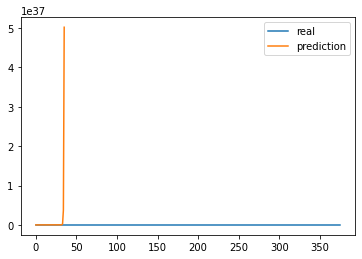

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

opt1 = Optimizer()
model = Sequential()
model.add(Dense(4))
model.add(Dense(4))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

for _ in range(3):
    predictions = np.zeros(len(x_train))
    predictions[0:4] = y_train[0:4, 0]
    for i in range(4, len(y_train)):
        model.fit(np.array([predictions[i-4:i]]), np.array([y_train[i, 0]]), verbose=0)
# model.compile(optimizer=Adam(learning_rate=.0001), 
#               loss=MeanSquaredError(), metrics=['mean_squared_error'])
# model.fit(x_train[:, 0, :], y_train[:, 0], batch_size=1, epochs=3)
# model.evaluate(x_test[:, 0, :], y_test[:, 0], batch_size=1)
model.summary()
# print(model.get_trainable_variables())
predictions = np.zeros(len(x_val))
pred2 = np.zeros(len(x_val))
predictions[0:4] = y_val[0:4, 0]
pred2[0:4] = y_val[0:4, 0]
for i in range(4, len(x_val)):
    predictions[i] = model.predict(np.array([predictions[i-4:i]]))
    pred2[i] = model.predict(np.array([y_val[i-4:i]]))
plt.plot(y_test[:, 0], label='real')
plt.plot(predictions, label='prediction')
plt.plot(pred2, label='val predictions')
plt.legend()
plt.show()


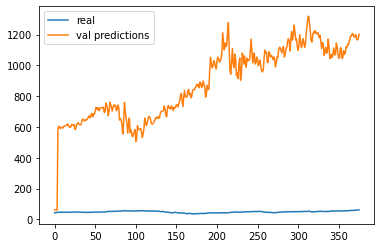

In [50]:
predictions = np.zeros(len(x_val))
pred2 = np.zeros(len(x_val))
predictions[0:4] = y_val[0:4, 0]
pred2[0:4] = x_val[0, 0, :]
for i in range(4, len(x_val)):
#     predictions[i] = model.predict(np.array([predictions[i-4:i]]))
    pred2[i] = model.predict(np.array([y_val[i-4:i, 0]]))
plt.plot(y_test[:, 0], label='real')
# plt.plot(predictions, label='prediction')
plt.plot(pred2, label='val predictions')
plt.legend()
plt.show()


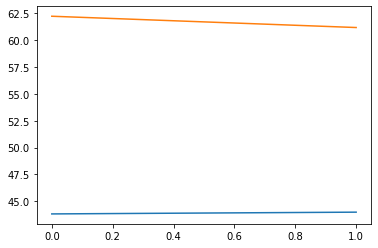

In [46]:
plt.cla()
plt.plot(y_test[:2, 0], label='real')
plt.plot(predictions[:2], label='prediction')
plt.show()

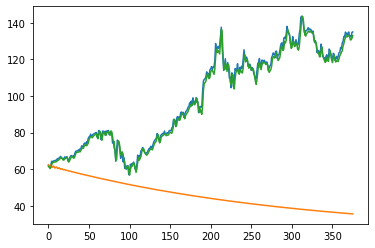

In [15]:
predictions = np.zeros(len(x_val))
predictions[0:4] = y_val[0:4, 0]
for i in range(4, len(x_val)):
    predictions[i] = model(np.array([predictions[i-4:i]]))
plt.cla()
plt.plot(y_val[:, 0])
plt.plot(predictions)
# plt.plot(model(x_val[:, 0]))
plt.show()